### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Run all cells** (in the menubar, select Runtime$\rightarrow$Run All).
3. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
4. **Add the downloaded notebook (.ipynb file) to the submission zip**.

Make sure you fill in any place that says `YOUR CODE HERE` or "**WRITE YOUR ANSWER IN THIS CELL**", and that no tests fail.  
Write the IDs of all group members in the cell below. Leave any surplus IDs as `""`.

ID1 = "301687901"
ID2 = "305640393"


---

![shakespeare](https://i.imgur.com/81YZuel.jpg)

# Generating Shakespeare Using a Character-level Language Model

### From Words to Characters
In the previous two sections we dealt with word-level language models. But looking again at section 2, there is nothing that constraints us to using _words_ as the basic elemnents in our model. The model we analyzed in section 2 could just as well be character-based - just replace "word" with "character", and you are good to go. In this notebook we will train a small character-based language model that will help us generate Shakespearean-like (emphasis on the _like_...) texts.

### Question 3.a
Can you think of an advantage a character-based language model could have over a word-based language model? _(You might find question 2.c useful)_. And what about the other way around: can you think of an advantage a word-based language model could have over a character-based language model?

**WRITE YOUR ANSWER IN THIS CELL**
From question 2.c. we can see that the operations we need to perform in both forward and backward dependent on |V|, which can be pretty big in Word-based model. However, in Character-based model |V| is limitted and not so big.
On the other hand, in case of Word-based model, the model can learn and perform better result because the generalization is better in Word-based case than Character-based.

### Using PyTorch

We'll build our language model using PyTorch. PyTorch is a [very popular](https://thegradient.pub/state-of-ml-frameworks-2019-pytorch-dominates-research-tensorflow-dominates-industry/) open-source machine learning (and deep learning) framework developed by Facebook. In short:

> Pytorch is a Python-based scientific computing package targeted at two sets of audiences:
* A replacement for NumPy to use the power of GPUs
* A deep learning research platform that provides maximum flexibility and speed

To get familiar with PyTorch, check out this [quick tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html). In addition, another imporant difference from numpy is that PyTorch can automatically calculate the gradients needed for backpropagation, as explained [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

### Preparing the Data

Our dataset is a plain text file. For simplicity, we turn any potential unicode characters into plain ASCII by using the `unidecode` package.

In [11]:
import string
import random
import re

import unidecode

all_characters = string.printable
n_characters = len(all_characters)  # our vocabulary size (|V| from the handout)

dataset_as_string = unidecode.unidecode(open('data/shakespeare.txt').read())
n_chars_in_dataset = len(dataset_as_string)
print(f'Total number of characters in our dataset: {n_chars_in_dataset}')

Total number of characters in our dataset: 1115394


To make inputs out of this big string of text, we will split it into chunks.

In [12]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, n_chars_in_dataset - chunk_len)
    end_index = start_index + chunk_len + 1
    return dataset_as_string[start_index:end_index]

print(random_chunk())


Sir, my lord,
I could do this, and that with no rash potion,
But with a lingering dram that should not work
Maliciously like poison: but I cannot
Believe this crack to be in my dread mistress,
So sovereignly being honourable.
I have loved thee,--

LEONTES:
Make that thy question, and go rot!
Dost think I am so muddy, so unsettled,
To appoint myself in this vexation, sully
The purity and whiteness 


### Building Our Model

Our model consists of three main components:

1. [**Embedding**](https://pytorch.org/docs/stable/nn.html#embedding). A mapping between characters and their learned representations ("word vectors") \[correspoding to ${\boldsymbol L}$ in terms of the handout\]
2. [**GRU**](https://pytorch.org/docs/stable/nn.html#gru). \[correspoding to the computation of ${\boldsymbol h}^{(t)}$ in terms of the handout\]
3. **Output Layer**. A feed-forward neural network that transforms a hidden state at a timestep into a probability distribution of the next character. \[correspoding to the computation of $\hat{\boldsymbol y}^{(t)}$ in terms of the handout\] 

### Question 3.b
Complete the implementation of the `forward` method of our model.

In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class OurModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(OurModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)  # In the terms of the handout, here d = D_h
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_, hidden):
        # General instructions:
        # Pass the embedded input through the GRU and use the output layer to get the next character distribution.
        # return that distribution and the next hidden state.
        # You may need to play around with the dimensions a bit until you get it right. Dimension-induced frustration is good for you!
        # -------------------------
        # YOUR CODE HERE
        if len(input_.shape) == 0:
            input_ = input_.unsqueeze(0)
        emb = self.embedding(input_)
        emb = emb.unsqueeze(0)
        out, hidden = self.gru(emb, hidden)
        output = self.output_layer(out)
        output = output.squeeze(0)
        # -------------------------
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

### Creating the Training Examples

Each chunk will be turned into a tensor by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [14]:
# Turn a string into list of longs
def chars_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(chars_to_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Each training example for our model will be created from a chunk randomly extracted from our shakespeare dataset. For example, if we set our chunk size to be 28, then a randomly extracted chunk could be $\texttt{As deep as that, though true}$. Each training example is of a form $(\textbf{x},\textbf{y})$ where $\textbf{x}$ is all the charecters of the chunk *except the last* and $\textbf{y}$ is all the charecters of the chunk *except the first*. For example, given the chunk above, $\textbf{x}=\texttt{As deep as that, though tru}$ and $\textbf{y}=\texttt{s deep as that, though true}$. At timestep i our input is $\textbf{x}^{(i)}$ and the gold label our model will try to predict is $\textbf{y}^{(i)}$.

In [15]:
def random_training_example():    
    chunk = random_chunk()
    inp = chars_to_tensor(chunk[:-1])
    target = chars_to_tensor(chunk[1:])
    return inp, target

### Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [16]:
import torch.nn.functional as F

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = model.init_hidden()
    prime_input = chars_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist =  F.softmax(output / temperature, dim=-1)
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = chars_to_tensor(predicted_char)

    return predicted

### Training

The main training function

In [17]:
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        loss += criterion(output, target[c].view(-1))

    loss.backward()
    optimizer.step()

    return loss.item() / chunk_len

A helper to print the amount of time passed:

In [18]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {math.floor(s)}s'

In [19]:
# DO NOT DELETE THIS CELL


Define the training parameters, instantiate the model, and start training:

In [20]:
n_iterations = 2000
print_every = 100
plot_every = 10
hidden_size = 100  # (D_h from the handout)
num_layers = 1
lr = 0.005

model = OurModel(n_characters, hidden_size, n_characters, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for iteration in range(1, n_iterations + 1):
    loss = train(*random_training_example())       
    loss_avg += loss

    if iteration % print_every == 0:
        print(f'[time elapsed: {time_since(start)}  ;  iterations: {iteration} ({iteration / n_iterations * 100}%)  ;  loss: {loss:.4}]')
        print(evaluate('Wh', 200), '\n')  # generate text starting with 'Wh'

    if iteration % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time elapsed: 0m 35s  ;  iterations: 100 (5.0%)  ;  loss: 2.198]
Why and oull bin.

CERICQUS:
Ou I the hapime thav venfesen te hert merea pall und pean ban sine he upeas mer has blel he path
hutich fat lod ared the ey,
He thath a het had me
hinis hipees ing you feand 

[time elapsed: 1m 12s  ;  iterations: 200 (10.0%)  ;  loss: 2.163]
Whe homade how thou losst in that thou to the ome thou wo rane, bentue to my the of weit, comefor me eath ane'd air, art the leart.

CUCER:
Wist brave ot wait tay my to manten, go his to molfor boder
jo 

[time elapsed: 1m 54s  ;  iterations: 300 (15.0%)  ;  loss: 1.995]
Whave lice wo love that the to stragey
And was be now, ing were his be the theee and the the madeds as moins the thins and as of your
By love, great, there
Will the prough mepus whis aoke the will notin 

[time elapsed: 2m 33s  ;  iterations: 400 (20.0%)  ;  loss: 2.141]
Whe him that with be, all wea her herse you harry be to by hing hime fathen make is in old!
How hear, not ontly but he

### Training Loss

Plotting the the losses that were computed during training can provide a further indication that the network was indeed learning.

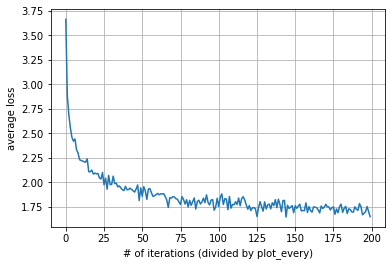

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.grid(True)
plt.xlabel('# of iterations (divided by plot_every)')
plt.ylabel('average loss')
plt.plot(all_losses)

### Evaluating at Different Temperatures
Every time we use the `evaluate` function to generate the distribution of the next character, we don't just use softmax as usual, but we also divide by a `temperature`.  
Let's examine the effect of changing the temperature when generating text using our trained model:

In [22]:
print(evaluate('Th', 400, temperature=0.1))

The words:
Which our so so the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the proud the with the with the with the with the with the with the with the with the with the with the with the with the with the proud the with the with the with the proud the with the with the with the with the with the


In [23]:
print(evaluate('Th', 400, temperature=0.5))

The the were for the deather:
Which to this so with stnown with faith pition:
I have for as the with that with me we so so he would.

GLOUCESTER:
And so so with the for your our to he with me deather:
Where the so with siting to his lord.

GLOUCESTER:
And self me a king of the with me.

GLOUCESTER:
My so the with his stone he with we
But a words to me a stright.

GREMIO:
What the which the lived the


In [24]:
print(evaluate('Th', 400, temperature=0.8))  # the default value

Th:
I may, leds, bearled, hand,
For his cheer the wond of we art desside
Such signse thou by stend there it.

BARGARD OF VINCENTIO:
What were, you riked to suren mory Lord-
GREMIUS:
But the kings his preds do alark,
And me confelve great aid yebary up so up is:
Whouse inted, a but dranfer and the show is every
Being to him his had we woo wither.

AUTUS:
What you have looks whereann'd is provines
For


In [25]:
print(evaluate('Th', 400, temperature=1))

Thee,
And, speres at through to in like rust;
And soublal fromin'd to our with spit thorman,
And says right speak as and
A go thir ye Lord yeavence,
In't to pleath miss the bread,
The carrsinss he his light, vanged sined: who the hath you;
Thou bovows in will ome Corood.
I hie true to and our hove, us;
A upon Oce are nurding prentued, and with our which,
Edy whill our now.

DO RIVESe
But of, to to n


In [26]:
print(evaluate('Th', 400, temperature=1.5))

Thom' for3R
Ze'ncelages.' vind houghtsets: he die, witunss elow?
gence. with' thy roschdrent tilaniraf; Pecoft
Naud, any how basticauaintuex thou''lila awhip ust.
Ob, thm thich crimazle.
Dleam besellent assqule., de, Polit?
O, t with troy a stanliow atom up;
For 'Joor destan; infez; aboul.
.
Lutty canholy---NicsaRe? yue.
Evhow nother priceastier she wearl.

GLOUF,e-hioseval hom, on,
Till becrictor I


### Question 3.c
How does the value of `temperature` affect the properties of the generated text?
Specifically address the process of sampling a character from the next character distribution, and the effect `temperature` has on it.

**WRITE YOUR ANSWER IN THIS CELL**
As we can see, as the temperature going far from the default value (0.8) the sentences become less logical and reasonable.
Dividing by T<1 makes the model's logits being bigger and the entire model is more "confident" with his decision but also the model becomes more "conservative", whereas dividing by T>1 makes out logits to be smaller and the model predict more diverse and mistable.